# CSI HAR
- Training:Validating:Testing = 6:2:2
- LSTM & Attention
- Random Search




## 1. Import libraries and dataset

In [271]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from numpy import dstack

# Data Scaling
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

!pip install tensorflow-addons
import tensorflow_addons as tfa

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention

!pip install keras-tuner
import kerastuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
from matplotlib.pyplot import figure

print('libraries have imported ')

libraries have imported 


In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [272]:
path = "/content/drive/MyDrive/final_project/Experiment3/Data"
os.chdir(path)
results = pd.DataFrame([])
list_file = glob.glob("*.csv") #lisiting all the csv files
print(list_file)

['Lying_Amp_104.csv', 'Lying_Amp_209.csv', 'Empty_Amp_197.csv', 'Lying_Amp_121.csv', 'Empty_Amp_172.csv', 'Lying_Amp_204.csv', 'Lying_Amp_17.csv', 'Lying_Amp_110.csv', 'Empty_Amp_185.csv', 'Empty_Amp_32.csv', 'Lying_Amp_123.csv', 'Lying_Amp_162.csv', 'Lying_Amp_128.csv', 'Empty_Amp_182.csv', 'Empty_Amp_254.csv', 'Empty_Amp_65.csv', 'Empty_Amp_38.csv', 'Empty_Amp_250.csv', 'Lying_Amp_201.csv', 'Empty_Amp_211.csv', 'Lying_Amp_153.csv', 'Empty_Amp_266.csv', 'Lying_Amp_174.csv', 'Lying_Amp_197.csv', 'Lying_Amp_173.csv', 'Lying_Amp_208.csv', 'Lying_Amp_179.csv', 'Lying_Amp_186.csv', 'Empty_Amp_54.csv', 'Empty_Amp_25.csv', 'Lying_Amp_184.csv', 'Lying_Amp_119.csv', 'Lying_Amp_124.csv', 'Empty_Amp_37.csv', 'Empty_Amp_239.csv', 'Lying_Amp_127.csv', 'Empty_Amp_263.csv', 'Lying_Amp_106.csv', 'Empty_Amp_221.csv', 'Empty_Amp_61.csv', 'Empty_Amp_85.csv', 'Lying_Amp_166.csv', 'Empty_Amp_189.csv', 'Empty_Amp_92.csv', 'Empty_Amp_215.csv', 'Empty_Amp_170.csv', 'Empty_Amp_2.csv', 'Empty_Amp_28.csv', 'Emp

## 2. Preprocessing

In [273]:
# function for reading CSV files
def reading_file(activity_csv):
    results = []
    for i in range(len(activity_csv)):
        df = pd.read_csv(activity_csv[i])
        results.append(df.values)
    return results

In [275]:
#Classify each csv files by its activity
empty_csv = [i for i in list_file if i.startswith('Empty')]
lying_csv = [i for i in list_file if i.startswith('Lying')]
sitting_csv = [i for i in list_file if i.startswith('Sitting')]
standing_csv = [i for i in list_file if i.startswith('Standing')]
walking_csv = [i for i in list_file if i.startswith('Walking')]

In [276]:
#calling reading_file function
empty = reading_file(empty_csv)
lying = reading_file(lying_csv)
sitting = reading_file(sitting_csv)
standing = reading_file(standing_csv)
walking = reading_file(walking_csv)

### Labelling

In [277]:
#function for labeling the samples
def label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1)

In [278]:
walking_label = label(walking, 'walking')
empty_label = label(empty, 'empty')
lying_label = label(lying, 'lying')
sitting_label = label(sitting, 'sitting')
standing_label = label(standing, 'standing')

In [279]:
#concatenate all the samples into one np array
array_tuple = (empty, lying, sitting,standing, walking)
data_X = np.vstack(array_tuple)

#concatenate all the label into one array
label_tuple = (empty_label, lying_label, sitting_label,standing_label,  walking_label)
data_y = np.vstack(label_tuple)

#randomise the sample
data_X, data_y= shuffle(data_X, data_y)

### Splitting

Training : Validating : Testing = 6 : 2 : 2

In [280]:
X = data_X
y = data_y

# split the data into training + validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split the training + validation set into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

### Standardisation

In [281]:
# Standardisation is necessary when using neural network
class Standard_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [282]:
sc = Standard_Scaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform (X_val)
X_test = sc.transform (X_test)

### OneHotEncoder

In [283]:
#Encode categorical features (Activity Names) as a one-hot numeric array.
en = OneHotEncoder()
y_train_en = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_en = OneHotEncoder().fit_transform(y_val.reshape(-1, 1)).toarray()
y_test_en = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

In [284]:
(X_train.shape, X_val.shape, X_test.shape, y_train_en.shape, y_val_en.shape, y_test_en.shape)

((720, 500, 256),
 (240, 500, 256),
 (241, 500, 256),
 (720, 5),
 (240, 5),
 (241, 5))

## 3. LSTM & Attention Design

In [285]:
class LSTMWithAttention(tf.keras.Model):
    def __init__(self, lstm_units, dropout_rate, dense_units, num_classes):
        super(LSTMWithAttention, self).__init__()
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_sequences=True)
        self.attention = tf.keras.layers.Attention(use_scale=True, score_mode="dot")
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.dense = tf.keras.layers.Dense(units=dense_units, activation='relu')
        self.final_dense = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, inputs):
        lstm_out = self.lstm(inputs)
        attention_out = self.attention([lstm_out, lstm_out])
        combined_out = self.flatten(attention_out)
        dropout_out = self.dropout(combined_out)
        dense_out = self.dense(dropout_out)
        return self.final_dense(dense_out)

In [286]:
# Create an instance of the model
activity_model = LSTMWithAttention(lstm_units=64, dropout_rate=0.5, dense_units=32, num_classes=y_train_en.shape[1])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
opt = keras.optimizers.Adam(learning_rate=1e-8)

# Compile the model
activity_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
activity_model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
activity_model.summary()

Model: "lstm_with_attention_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  82176     
                                                                 
 attention_1 (Attention)     multiple                  1         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  1024032   
                                                                 
 dense_3 (Dense)             multiple                  165       
                                                                 
Total params: 1106374 (4.22 MB)
Trainable par

## 4. Model Training

In [312]:
model_history = activity_model.fit(X_train, y_train_en, epochs= 100, validation_data=(X_val, y_val_en),  batch_size=32, callbacks = [lr_schedule])

Epoch 1/100
23/23 [==============================] - 7s 319ms/step - loss: 3.7473e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 7s 292ms/step - loss: 3.6351e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 7s 296ms/step - loss: 3.5665e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 7s 292ms/step - loss: 3.7004e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 7s 297ms/step - loss: 3.6446e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 7s 286ms/step - loss: 3.6449e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9750 - lr: 1.7783e-08
Epoch 7/100
23/2

# Model History plot

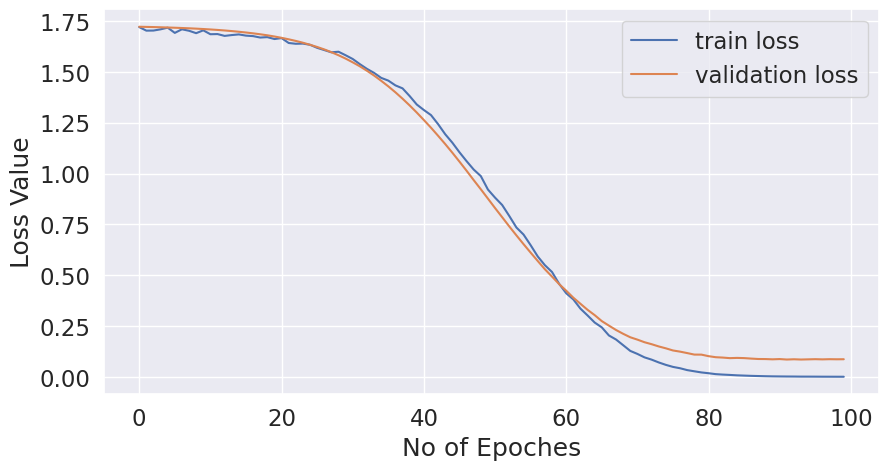

In [309]:
# plot history
figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

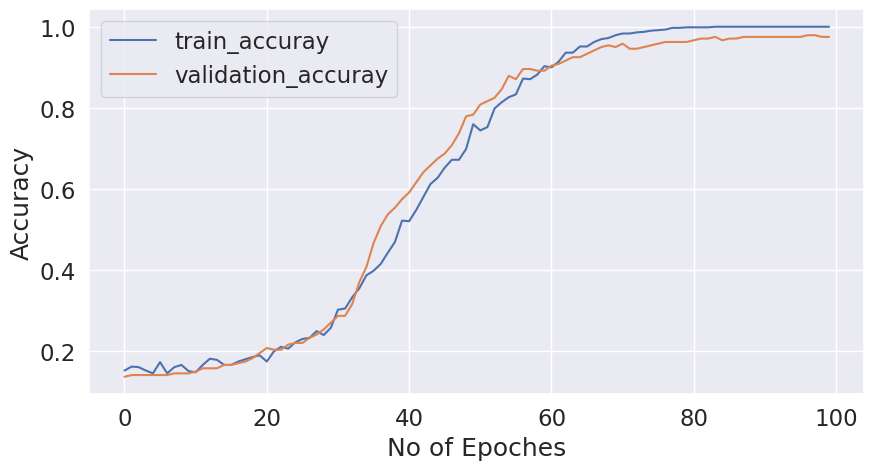

In [310]:
# plot history
figure(figsize=(10, 5))
plt.plot(model_history.history['accuracy'], label='train_accuray')
plt.plot(model_history.history['val_accuracy'], label='validation_accuray')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

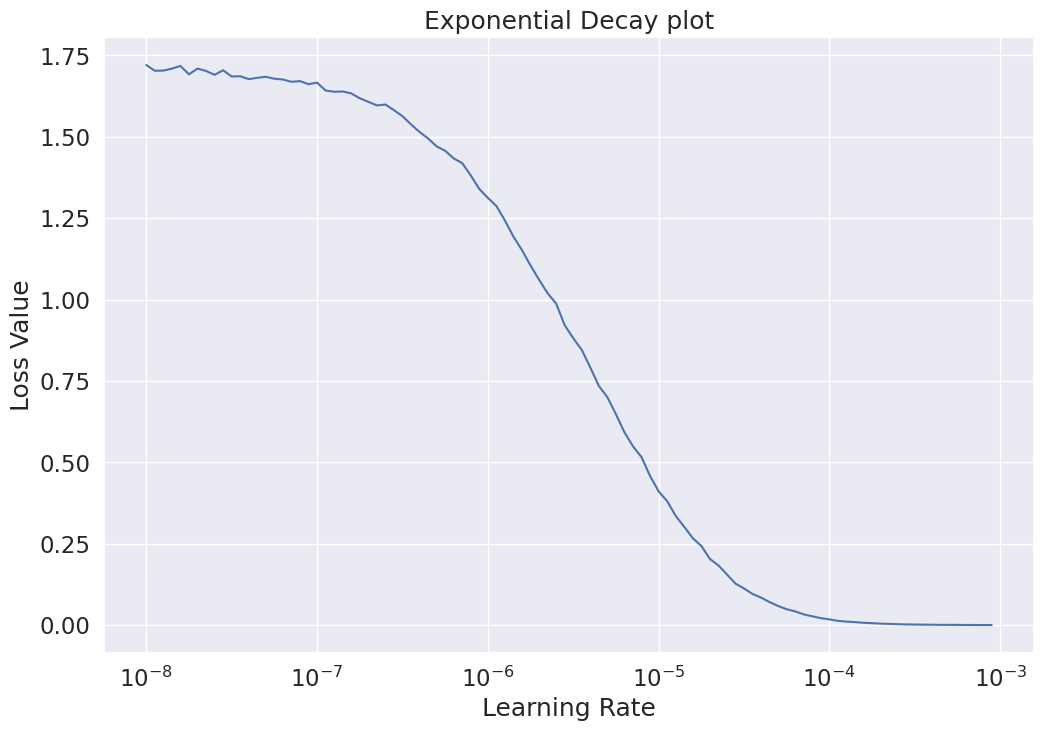

In [311]:
# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

### Choose the best learning rate

In [289]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = LSTMWithAttention(lstm_units=64, dropout_rate=0.5, dense_units=32, num_classes=y_train_en.shape[1])

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

In [290]:
history = model.fit(X_train, y_train_en, epochs= 50, batch_size=32, validation_data=(X_val, y_val_en), callbacks = [callbacks, earlystopping])

Epoch 1/50
23/23 [==============================] - 9s 325ms/step - loss: 0.5356 - accuracy: 0.7972 - val_loss: 0.1025 - val_accuracy: 0.9583
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9778
Accuracy has reached to threshold (98%) so stopping training!
23/23 [==============================] - 7s 286ms/step - loss: 0.0690 - accuracy: 0.9778 - val_loss: 0.0957 - val_accuracy: 0.9833


In [291]:
model.evaluate(X_val, y_val_en)

8/8 [==============================] - 1s 91ms/step - loss: 0.0957 - accuracy: 0.9833


[0.09571881592273712, 0.9833333492279053]

# Optimisation

In [294]:
class LSTMWithAttentionHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
        dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])

        model = LSTMWithAttention(lstm_units=lstm_units,
                                  dense_units=dense_units,
                                  dropout_rate=dropout_rate,
                                  num_classes=self.num_classes)

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

num_classes = y_train_en.shape[1]

In [295]:
# Instantiate the HyperModel
hypermodel = LSTMWithAttentionHyperModel(num_classes=num_classes)

# Define the RandomSearch tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='/content/drive/MyDrive/final_project/Experiment3',  # Where to save the results
    project_name='lstm_with_attention_tuning2.0'
)

In [296]:
callbacks = myCallback()

# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Restore the weights of the best epoch
)

In [297]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [298]:
# Run the random search
tuner.search(X_train, y_train_en, epochs=20, validation_data=(X_val, y_val_en), callbacks=[callbacks, early_stopping])

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.9750000238418579

Best val_accuracy So Far: 0.9833333492279053
Total elapsed time: 00h 21m 55s


In [299]:
# Display a summary of the search results
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/final_project/Experiment3/lstm_with_attention_tuning2.0
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
lstm_units: 32
dense_units: 48
dropout_rate: 0.4
learning_rate: 0.0001
Score: 0.9833333492279053

Trial 01 summary
Hyperparameters:
lstm_units: 32
dense_units: 48
dropout_rate: 0.3
learning_rate: 0.01
Score: 0.9833333492279053

Trial 03 summary
Hyperparameters:
lstm_units: 128
dense_units: 32
dropout_rate: 0.5
learning_rate: 0.001
Score: 0.9833333492279053

Trial 05 summary
Hyperparameters:
lstm_units: 224
dense_units: 32
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.9833333492279053

Trial 07 summary
Hyperparameters:
lstm_units: 64
dense_units: 48
dropout_rate: 0.5
learning_rate: 0.0001
Score: 0.9833333492279053

Trial 06 summary
Hyperparameters:
lstm_units: 64
dense_units: 16
dropout_rate: 0.5
learning_rate: 0.001
Score: 0.9791666865348816

Trial 08 summary
Hyperparameters

In [300]:
# Display the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'lstm_units': 32, 'dense_units': 48, 'dropout_rate': 0.4, 'learning_rate': 0.0001}


In [301]:
best_model = tuner.get_best_models(num_models=1)[0]

In [303]:
best_model.evaluate(X_val, y_val_en)

8/8 [==============================] - 1s 60ms/step - loss: 0.0819 - accuracy: 0.9833


[0.08187510818243027, 0.9833333492279053]

# III. Result

## 5. Model Evaluation

In [304]:
#prediction on test data set
y_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_en)
print(f"Test Accuracy: {test_accuracy}")

8/8 [==============================] - 1s 65ms/step - loss: 0.1512 - accuracy: 0.9668
Test Accuracy: 0.9668049812316895


# Confusion Matrix

In [305]:
confusion_matrix = confusion_matrix(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'Lying', 'Sitting','Standing','Walking']
columns = ['Empty', 'Lying', 'Sitting','Standing','Walking']
df_cm = pd.DataFrame(confusion_matrix,columns,index)

Text(0.5, 13.249999999999995, 'Predicted Activities')

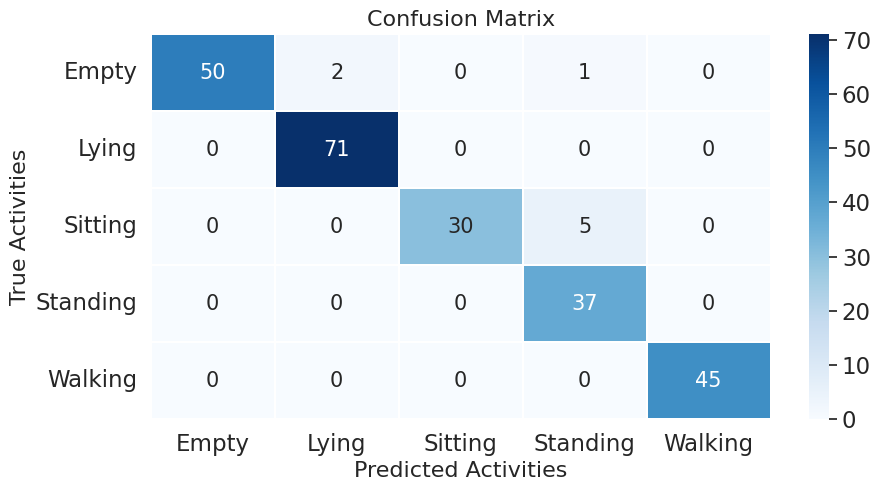

In [306]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [307]:
# Classification Report
target_names = ['Empty', 'Lying', 'Sitting','Standing','Walking']
print(classification_report(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

       Empty       1.00      0.94      0.97        53
       Lying       0.97      1.00      0.99        71
     Sitting       1.00      0.86      0.92        35
    Standing       0.86      1.00      0.92        37
     Walking       1.00      1.00      1.00        45

    accuracy                           0.97       241
   macro avg       0.97      0.96      0.96       241
weighted avg       0.97      0.97      0.97       241

